In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from collections import namedtuple, deque
import random
import math
%matplotlib inline
from IPython import display
import pandas as pd

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
env_filter = namedtuple('env_filter',
                        ('state', 'action', 'next_state', 'reward'))

In [5]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]  # crop and downsize
    img = img.sum(axis=2)  # to greyscale
    img[img==mspacman_color] = 0  # Improve contrast
    img = (img // 3 - 128).astype(np.int8)  # normalize from -128 to 127
    return img.reshape(88, 80, 1)

In [6]:
class replay_bank(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def store(self, state, action, next_state, reward):
        self.memory.append(env_filter(state, action, next_state, reward))

    def recall(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def printout(self):
        print(self.memory)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQCNN(nn.Module):
    def __init__(self, action_size):
        super(DQCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 11 * 10, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [8]:
class agent:
    
    def __init__(self, env):
        
        self.env = env
        
        self.action_size = env.action_space.n
        self.state , _ = env.reset()
        self.state = preprocess_observation(self.state)

        self.state_size = len(self.state)

        self.batch_size = 16

        self.learning_rate = 1e-4

        self.gamma = 0.99
        self.epsilon = 0.9
        self.epsilon_min = 0.05
        self.epsilon_decay = 1000

        self.tau = 0.005
        
        self.memory = replay_bank(10000)
        
        self.policy_net = DQCNN(self.action_size).to(device)
        self.target_net = DQCNN(self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.learning_rate)
        self.criterion = nn.SmoothL1Loss()
        
        self.steps_done = 0
        
        self.loss_list = []
        self.loss_avg = []
        self.max_q = float('-inf')
        self.max_q_vals = []
        
    def remember(self, state, action, next_state, reward):
        self.memory.store(state, action, next_state, reward)
        
    def show_memory(self):
        self.memory.print()
    
        '''
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return torch.tensor(random.randrange(self.action_size), device=device, dtype=torch.long).max()
        state_tensor = torch.tensor(state).to(device)
        action = self.policy_net(state).max(1)[1].view(1, 1)
        return action
    '''
    def act(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                #print(self.policy_net(state).max(1))
                return self.policy_net(state).max(1)[1].view(1, 1), self.policy_net(state).max(1)[0].cpu().detach().numpy()
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long), 0
        
    def log(self, loss, max_q):
        self.loss_list.append(loss)
        self.loss_avg.append(np.mean(self.loss_list[-100:]))
        self.max_q_vals.append(max_q)
        
    def learn(self):
        
        if len(self.memory) < self.batch_size:
            return
        
        recall = self.memory.recall(self.batch_size)
        
        bank = env_filter(*zip(*recall))
        state_bank = torch.cat(bank.state).to(device)
        #print(state_bank.size())
        
        action_bank = torch.cat(bank.action).to(device)
        #print(action_bank.size())
        reward_bank = torch.cat(bank.reward)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          bank.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in bank.next_state
                                                if s is not None])
        
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_vals = (next_state_values * self.gamma) + reward_bank
        
        action_vals = self.policy_net(state_bank).gather(1, action_bank)
        self.max_q = max(self.max_q, torch.max(action_vals))

        #print(action_vals)
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        loss = self.criterion(action_vals, expected_vals.unsqueeze(1))
        
        self.log(loss.cpu().detach().numpy(),self.max_q.cpu().detach().numpy())
        
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1)
        self.optimizer.step()
        
        
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_net.load_state_dict(target_net_state_dict)
        
        
        
        

In [9]:
env = gym.make('MsPacman-v0', render_mode='rgb_array')


/nfs/home/dwm7542/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


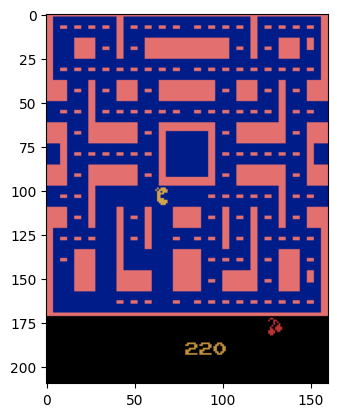

Episode 1 finished with a score of 220.0.
Episode 11 finished with a score of 820.0.
Episode 21 finished with a score of 560.0.
Episode 31 finished with a score of 1340.0.
Episode 41 finished with a score of 440.0.
Episode 51 finished with a score of 380.0.
Episode 61 finished with a score of 600.0.
Episode 71 finished with a score of 520.0.
Episode 81 finished with a score of 1270.0.
Episode 91 finished with a score of 2340.0.
Episode 101 finished with a score of 710.0.
Episode 111 finished with a score of 1020.0.
Episode 121 finished with a score of 1120.0.
Episode 131 finished with a score of 250.0.
Episode 141 finished with a score of 1230.0.
Episode 151 finished with a score of 2270.0.
Episode 161 finished with a score of 1700.0.
Episode 171 finished with a score of 860.0.
Episode 181 finished with a score of 1040.0.
Episode 191 finished with a score of 270.0.
Episode 201 finished with a score of 1260.0.
Episode 211 finished with a score of 1240.0.
Episode 221 finished with a scor

In [ ]:
num_episodes = 1500

mspacman_agent = agent(env)

ep_rewards = []
rolling_rewards = []
max_q_vals = []

for ep in range(num_episodes):
    done = False
    truncated = False
    reward_history = []
    state, info = env.reset()
    state = torch.tensor(preprocess_observation(state)).float().to(device).unsqueeze(0)
    state = state.permute(0, 3, 1, 2) 

    step_idx = 0
    
    max_q = float('-inf')
    while not (done or truncated):
        
        action, q_val = mspacman_agent.act(state)
        max_q = max(max_q, q_val)
        
        frame, reward, done, truncated, info = env.step(action)
        reward_history.append(reward)
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(preprocess_observation(frame), dtype=torch.float32, device=device).unsqueeze(0)
            next_state = next_state.permute(0,3,1,2)
            
        
            
        mspacman_agent.remember(state, action, next_state, reward)
        
        state = next_state
        
        mspacman_agent.learn()
        

        
        if ep % 1000 ==0:

            if step_idx % 4 == 0:
                # For display: can be slow
                plt.clf()
                plt.imshow(env.render())
                display.clear_output(wait=True)
                display.display(plt.gcf())

            step_idx += 1
    ep_rewards.append(sum(reward_history))
    rolling_rewards.append(np.mean(ep_rewards[-100:]))
    max_q_vals.append(max_q)
    
    if ep % 10 ==0:
        print(f"Episode {ep + 1} finished with a score of {sum(reward_history)}.")


In [ ]:
rolling_average = pd.Series(ep_rewards).rolling(window=100).mean()


plt.figure(figsize=(10, 6))
plt.plot(ep_rewards, marker='o', label = 'Original')
plt.plot(rolling_average, marker='.', color='red', label='Rolling Average per 100')

plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('results/mspacman_rewards.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_rewards, marker='o')

plt.title('Rolling Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward (per 100)')lae
plt.savefig('results/mspacman_rolling_rewards.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mspacman_agent.loss_avg, marker='o')

plt.title('Average Loss')
plt.xlabel('Iteration')
plt.ylabel('Average Loss (per 100)')
plt.savefig('results/mspacman_loss.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(max_q_vals, marker='o')

plt.title('Max Q Values Per Episode over Time')
plt.xlabel('Episode')
plt.ylabel('Q-Val')
plt.savefig('results/mspacman_max_q_episodes.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mspacman_agent.max_q_vals, marker='o')

plt.title('Overall Max Q Values over Time')
plt.xlabel('Iteration')
plt.ylabel('Q-Val')
plt.savefig('results/mspacman_max_q_Overall.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

In [ ]:
ep_mean =np.mean(ep_rewards[-500:])
ep_sd =np.std(ep_rewards[-500:])
ep_mean

In [ ]:
ep_sd